In [28]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

# Step 1. Naive simulation.
- Simulate N bodies
- There's a transmission rate 
- At each time step, all the infected people have some *transmission rate* probability of infecting everyone.
- Just tracking rate of *infection* through. Don't worry about death.
- 0 dimensional problem

In [92]:
# 1 is healthy. 0 is not.
def infect(df, trans_rate, day_name): # need to speed up
    p = trans_rate # to confer correct healthy/sick convention.
    for i in range(len(df)):
        if df['infected'][i] == 0.0: # if infected, infect others
            infect_col = np.random.binomial(size=len(df), p=trans_rate, n=1) # 1 toss, siz
            df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"] * infect_col
    return df

def simulate(N, trans_rate, t_steps, N_initial):
    # making separate name column because indices get messy. 
    # other cols later.
    d = {'name': np.arange(N), 'infected day 0': np.ones(N)} 

    df = pd.DataFrame(data=d)
    
    df.loc[:N_initial, 'infected'] = 0 # Make first N_initial people sick 
    t = 1
    while t < t_steps:
        df = infect(df, trans_rate, t)
        t += 1
    return df
        

In [93]:
%%time
df = simulate(100000, .1, 30, 1)

CPU times: user 1min, sys: 400 ms, total: 1min
Wall time: 1min 2s


In [ ]:
dc

Text(0, 0.5, 'Number of infected individuals')

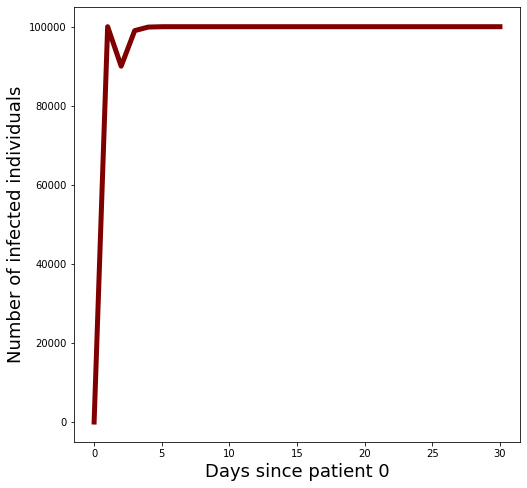

In [96]:
plt.figure(figsize=(8,8))
infections = np.array([df[col].sum() for col in df.columns if 'infected' in col])
plt.plot(np.arange(len(infections)), 100000 - infections, lw=5, color='maroon')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')

In [97]:
infections

array([1.000e+05, 0.000e+00, 9.987e+03, 9.960e+02, 1.000e+02, 6.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00])